# RVI calculator

### Libraries

In [16]:
import os
import rasterio
import json
import requests
import subprocess
import gc
import shutil
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from math import cos, radians

### Select the area to analyze

In [88]:
# nad puszcza kampiniowska - spoko ale dupy nie urywa
x = 20.446018
y = 52.444681

# x = 22.815597
# y = 53.461864

offset_km = 5

### Calculation of corner points' coordinates

In [89]:
lat_offset = offset_km / 111.0
lon_offset = offset_km / (111.0 * cos(radians(y)))

left_x = (x - lon_offset)
right_x = (x + lon_offset)
bottom_y = (y - lat_offset)
top_y = (y + lat_offset)
 
bottom_left = f"{left_x}%20{bottom_y}"
top_left = f"{left_x}%20{top_y}"
bottom_right = f"{right_x}%20{bottom_y}"
top_right = f"{right_x}%20{top_y}"

print(left_x)
print(top_y)

20.372116375170748
52.489726045045046


### Product lists for every corner of the area

In [90]:
start_date = (datetime.today() - timedelta(days=30)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

url_bottom_left = f"https://datahub.creodias.eu/odata/v1/Products?$filter=((ContentDate/Start%20ge%20{start_date}T00:00:00.000Z%20and%20ContentDate/Start%20le%20{end_date}T23:59:59.999Z)%20and%20(Online%20eq%20true)%20and%20(OData.CSC.Intersects(Footprint=geography%27SRID=4326;POINT%20({bottom_left})%27))%20and%20(((((Collection/Name%20eq%20%27SENTINEL-1%27)%20and%20(((Attributes/OData.CSC.StringAttribute/any(i0:i0/Name%20eq%20%27productType%27%20and%20i0/Value%20eq%20%27GRD-COG%27))))%20and%20(((Attributes/OData.CSC.StringAttribute/any(i0:i0/Name%20eq%20%27polarisationChannels%27%20and%20i0/Value%20eq%20%27VV%26VH%27)))))))))&$expand=Attributes&$expand=Assets&$orderby=ContentDate/Start%20asc&$top=20"
url_bottom_right = f"https://datahub.creodias.eu/odata/v1/Products?$filter=((ContentDate/Start%20ge%20{start_date}T00:00:00.000Z%20and%20ContentDate/Start%20le%20{end_date}T23:59:59.999Z)%20and%20(Online%20eq%20true)%20and%20(OData.CSC.Intersects(Footprint=geography%27SRID=4326;POINT%20({top_left})%27))%20and%20(((((Collection/Name%20eq%20%27SENTINEL-1%27)%20and%20(((Attributes/OData.CSC.StringAttribute/any(i0:i0/Name%20eq%20%27productType%27%20and%20i0/Value%20eq%20%27GRD-COG%27))))%20and%20(((Attributes/OData.CSC.StringAttribute/any(i0:i0/Name%20eq%20%27polarisationChannels%27%20and%20i0/Value%20eq%20%27VV%26VH%27)))))))))&$expand=Attributes&$expand=Assets&$orderby=ContentDate/Start%20asc&$top=20"
url_top_left = f"https://datahub.creodias.eu/odata/v1/Products?$filter=((ContentDate/Start%20ge%20{start_date}T00:00:00.000Z%20and%20ContentDate/Start%20le%20{end_date}T23:59:59.999Z)%20and%20(Online%20eq%20true)%20and%20(OData.CSC.Intersects(Footprint=geography%27SRID=4326;POINT%20({bottom_right})%27))%20and%20(((((Collection/Name%20eq%20%27SENTINEL-1%27)%20and%20(((Attributes/OData.CSC.StringAttribute/any(i0:i0/Name%20eq%20%27productType%27%20and%20i0/Value%20eq%20%27GRD-COG%27))))%20and%20(((Attributes/OData.CSC.StringAttribute/any(i0:i0/Name%20eq%20%27polarisationChannels%27%20and%20i0/Value%20eq%20%27VV%26VH%27)))))))))&$expand=Attributes&$expand=Assets&$orderby=ContentDate/Start%20asc&$top=20"
url_top_right = f"https://datahub.creodias.eu/odata/v1/Products?$filter=((ContentDate/Start%20ge%20{start_date}T00:00:00.000Z%20and%20ContentDate/Start%20le%20{end_date}T23:59:59.999Z)%20and%20(Online%20eq%20true)%20and%20(OData.CSC.Intersects(Footprint=geography%27SRID=4326;POINT%20({top_right})%27))%20and%20(((((Collection/Name%20eq%20%27SENTINEL-1%27)%20and%20(((Attributes/OData.CSC.StringAttribute/any(i0:i0/Name%20eq%20%27productType%27%20and%20i0/Value%20eq%20%27GRD-COG%27))))%20and%20(((Attributes/OData.CSC.StringAttribute/any(i0:i0/Name%20eq%20%27polarisationChannels%27%20and%20i0/Value%20eq%20%27VV%26VH%27)))))))))&$expand=Attributes&$expand=Assets&$orderby=ContentDate/Start%20asc&$top=20"

paths_bottom_left = []  
paths_top_left = []
paths_bottom_right = []
paths_top_right = []
 
products = json.loads(requests.get(url_bottom_left).text)  
for item in products['value']:
    paths_bottom_left.append(item['S3Path'])

paths_bottom_left.reverse()
 
products = json.loads(requests.get(url_top_left).text)  
for item in products['value']:
    paths_top_left.append(item['S3Path'])
 
paths_top_left.reverse()
 
products = json.loads(requests.get(url_bottom_right).text)  
for item in products['value']:
    paths_bottom_right.append(item['S3Path'])
 
paths_bottom_right.reverse()
 
products = json.loads(requests.get(url_top_right).text)  
for item in products['value']:
    paths_top_right.append(item['S3Path'])
 
paths_top_right.reverse()

### Finding newest common product for all lists

In [91]:
set_bottom_left = set(paths_bottom_left)
set_top_left = set(paths_top_left)
set_bottom_right = set(paths_bottom_right)
set_top_right = set(paths_top_right)
 
product_path = None
 
for value in paths_bottom_left:
    if (value in set_top_left) and (value in set_bottom_right) and (value in set_top_right):
        product_path = value
        break
 
if product_path:
    print(f"The newest common product for all four lists: {product_path}")
else:
    print("No common product found for all four lists.")

The newest common product for all four lists: /eodata/Sentinel-1/SAR/IW_GRDH_1S-COG/2024/08/29/S1A_IW_GRDH_1SDV_20240829T045247_20240829T045312_055423_06C28D_440D_COG.SAFE


### Copying Sentinel 1 data 

In [92]:
destination_root = "/home/eouser/project/vegetation/safe_files"
folder_name = os.path.basename(product_path)
destination_path = os.path.join(destination_root, folder_name)

if os.path.isdir(destination_path):
    print("File already exist")
else:
    shutil.copytree(product_path, destination_path)
    
    for root, dirs, files in os.walk(destination_path):
        for dir_name in dirs:
            os.chmod(os.path.join(root, dir_name), 0o755)
        for file_name in files:
            os.chmod(os.path.join(root, file_name), 0o644)
    
    print(f"Directory '{folder_name}' has been copied to '{destination_path}'")


Directory 'S1A_IW_GRDH_1SDV_20240829T045247_20240829T045312_055423_06C28D_440D_COG.SAFE' has been copied to '/home/eouser/project/vegetation/safe_files/S1A_IW_GRDH_1SDV_20240829T045247_20240829T045312_055423_06C28D_440D_COG.SAFE'


### Terrain correction with SNAP graph

In [94]:
graph_template = "/home/eouser/project/vegetation/graph_rvi_template_tc.xml"
gpt_path = "/home/eouser/newsnap/snap/bin/gpt"
path = f"/home/eouser/project/vegetation/safe_files/{folder_name}"
 
base_name = os.path.splitext(os.path.basename(path))[0]
array = product_path.split("/")
name = f"{array[5]}_{array[6]}_{array[7]}"
 
output_tiff = f"/home/eouser/project/vegetation/terrain_corrected/tc_{name}_{y}-{x}.tif"
output_dim = f"/home/eouser/project/vegetation/terrain_corrected/tc_{name}_{y}-{x}.dim"
 
with open(graph_template, 'r') as file:
    graph_xml = file.read()
 
graph_xml = graph_xml.replace("INPUT_SAFE_FILE", path)
graph_xml = graph_xml.replace("OUTPUT_TIFF", output_tiff)
graph_xml = graph_xml.replace("OUTPUT_DIM", output_dim) 
 
modified_graph_file = f"/home/eouser/project/vegetation/rvi_graphs/{name}.xml"
with open(modified_graph_file, 'w') as file:
    file.write(graph_xml)
 
command = [gpt_path, modified_graph_file]
 
subprocess.run(command)

INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.


Executing processing graph


/home/eouser/.snap/auxdata/gdal/gdal-3-7-2/lib/jni/../libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /usr/lib/x86_64-linux-gnu/gio/modules/libgiolibproxy.so
Orbit files may be downloaded from Copernicus Dataspaces 
and placed in /home/eouser/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2024/08


....10%....20%....30%....40%....50%....60%....70%....80%....90% done.


CompletedProcess(args=['/home/eouser/newsnap/snap/bin/gpt', '/home/eouser/project/vegetation/rvi_graphs/2024_08_29.xml'], returncode=0)

### Calculation of subset coordinates

In [95]:
kwargs = {'format': 'VRT'}
gdal.Warp('/tmp/vrt.vrt', output_tiff, **kwargs)

with rasterio.open('/tmp/vrt.vrt') as dataset:
    transform = dataset.transform
    width = dataset.width
    height = dataset.height

    def find_pixels_cords(east, north):
        row, col = ~transform * (east, north)
        
        row = int(round(row))
        col = int(round(col))
        
        return [row, col]

    start_x, start_y = find_pixels_cords(left_x, top_y)
    end_x, end_y = find_pixels_cords(right_x, bottom_y)

width_x = f"{end_x - start_x}"
height_y = f"{end_y - start_y}"

start_x = f"{start_x}"
start_y = f"{start_y}"

print(f"start x: {start_x}, width: {width_x}")
print(f"start y: {start_y}, height: {height_y}")

start x: 22838, width: 1645
start y: 10652, height: 1003


### Clipping rasters with SNAP graph

In [96]:
graph_template = "/home/eouser/project/vegetation/graph_rvi_template_sub.xml"
gpt_path = "/home/eouser/newsnap/snap/bin/gpt"
 
output_file_vv = f"/home/eouser/project/vegetation/vv_vh_files/vv_{name}_{y}-{x}.tif"
output_file_vh = f"/home/eouser/project/vegetation/vv_vh_files/vh_{name}_{y}-{x}.tif"
 
with open(graph_template, 'r') as file:
    graph_xml = file.read()
 
graph_xml = graph_xml.replace("INPUT_DIM_FILE", output_dim)
graph_xml = graph_xml.replace("OUTPUT_VV_FILE", output_file_vv)
graph_xml = graph_xml.replace("OUTPUT_VH_FILE", output_file_vh)
graph_xml = graph_xml.replace("START_X", start_x) 
graph_xml = graph_xml.replace("START_Y", start_y) 
graph_xml = graph_xml.replace("WIDTH_X", width_x) 
graph_xml = graph_xml.replace("HEIGHT_Y", height_y) 
 
modified_graph_file = f"/home/eouser/project/vegetation/rvi_graphs/{name}.xml"
with open(modified_graph_file, 'w') as file:
    file.write(graph_xml)
 
command = [gpt_path, modified_graph_file]
 
subprocess.run(command)

INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.


Executing processing graph
....12%....23%....34%....46%....57%....68%....79%....90% done.


CompletedProcess(args=['/home/eouser/newsnap/snap/bin/gpt', '/home/eouser/project/vegetation/rvi_graphs/2024_08_29.xml'], returncode=0)

### Deleting Sentinel 1 data

In [97]:
cmd = "sudo rm -rf /home/eouser/project/vegetation/safe_files"
os.system(cmd)
os.mkdir("/home/eouser/project/vegetation/safe_files")

### Calculation of RVI

In [100]:
def normalize_image(image, new_min, new_max, no_data_value=None):

    if no_data_value is not None:
        valid_data = np.ma.masked_equal(image, no_data_value)
    else:
        valid_data = np.ma.masked_invalid(image)

    min_val = valid_data.min()
    max_val = valid_data.max()
    normalized_image = ((image - min_val) / (max_val - min_val)) * (new_max - new_min) + new_min
    normalized_image = np.clip(normalized_image, new_min, new_max)
    
    return normalized_image

array = product_path.split("/")
name = f"{array[5]}_{array[6]}_{array[7]}"

vv_tiff = f"/home/eouser/project/vegetation/vv_vh_files/vv_{name}_{y}-{x}.tif"
vh_tiff = f"/home/eouser/project/vegetation/vv_vh_files/vh_{name}_{y}-{x}.tif"
output_tiff = f"/home/eouser/project/vegetation/rvi_output/rvi_{name}_{y}-{x}.tif"

with rasterio.open(vv_tiff) as vv_src, rasterio.open(vh_tiff) as vh_src:
    vv = vv_src.read(1).astype(np.float32)
    vh = vh_src.read(1).astype(np.float32)

    no_data_value_vv = vv_src.nodata if vv_src.nodata is not None else None
    no_data_value_vh = vh_src.nodata if vh_src.nodata is not None else None

    vv_n = normalize_image(vv, 0, 1, no_data_value_vv)
    vh_n = normalize_image(vh, 0, 1, no_data_value_vh)

    rvi = np.divide(4 * vh_n, vv_n + vh_n, out=np.zeros_like(vv_n, dtype=float), where=(vv_n + vh_n) != 0)
    rvi = np.clip(rvi, 1.9, 2.3)

    profile = vv_src.profile
    profile.update(
        dtype=rvi.dtype,
        count=1,
        compress='lzw',
        transform=vv_src.transform,
        crs=vv_src.crs
    )

    with rasterio.open(output_tiff, 'w', **profile) as dst:
        dst.write(rvi, 1)

    del vv, vh, vv_n, vh_n, rvi        
    gc.collect()
    print(f"RVI has been saved to {output_tiff}")
    
vv_src.close()
vh_src.close()

RVI has been saved to /home/eouser/project/vegetation/rvi_output/rvi_2024_08_29_52.444681-20.446018.tif


### Visualization of RVI 

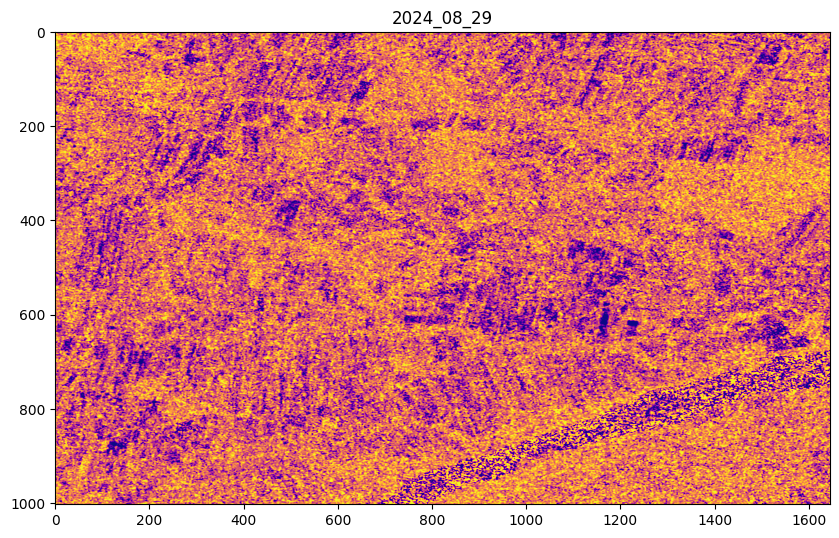

In [101]:
file = f"/home/eouser/project/vegetation/rvi_output/rvi_{name}_{y}-{x}.tif"

with rasterio.open(file) as src:
    src = src.read(1)

    plt.figure(figsize=(10, 10))
    plt.imshow(src, cmap='plasma')
    plt.title(name)
    plt.show()